In [1]:
import cv2
import numpy as np
from matplotlib import pylab as plt

In [2]:
image = cv2.imread('input.png', cv2.IMREAD_UNCHANGED)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)

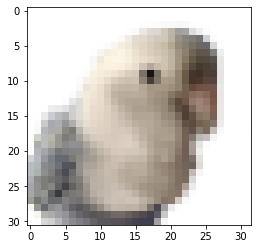

In [3]:
plt.imshow(image)

In [4]:
QOI_INDEX   = 0x00 # 00xxxxxx
QOI_RUN_8   = 0x40 # 010xxxxx
QOI_RUN_16  = 0x60 # 011xxxxx
QOI_DIFF_8  = 0x80 # 10xxxxxx
QOI_DIFF_16 = 0xc0 # 110xxxxx
QOI_DIFF_24 = 0xe0 # 1110xxxx
QOI_COLOR   = 0xf0 # 1111xxxx

QOI_MASK_2  = 0xc0 # 11000000
QOI_MASK_3  = 0xe0 # 11100000
QOI_MASK_4  = 0xf0 # 11110000

def QOI_COLOR_HASH(C):
    return (C[0] ^ C[1] ^ C[2] ^ C[3])

QOI_MAGIC = bytes([ord('q'), ord('o'), ord('i'), ord('f')])
QOI_HEADER_SIZE = 14
QOI_PADDING = 4

QOI_SRGB = 0x00
QOI_SRGB_LINEAR_ALPHA = 0x01
QOI_LINEAR = 0x0f

In [5]:
def bh(bytez): # Bytes to hex
    return bytez.hex().upper()

def int_to_bytes(x):
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

def int_from_bytes(xbytes):
    return int.from_bytes(xbytes, 'big')

In [6]:
def qoi_write_32(bytez, p, v):
    bytez[p] = (0xff000000 & int_from_bytes(v)) >> 24
    p += 1
    bytez[p] = (0x00ff0000 & int_from_bytes(v)) >> 16
    p += 1
    bytez[p] = (0x0000ff00 & int_from_bytes(v)) >> 8
    p += 1
    bytez[p] = (0x000000ff & int_from_bytes(v))
    p += 1
    return p

In [7]:
def encode(image):
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]

    max_size = width * height * (channels + 1) + QOI_HEADER_SIZE + QOI_PADDING;
    p = 0
    bytez = bytearray(max_size)

    p = qoi_write_32(bytez, p, QOI_MAGIC)
    p = qoi_write_32(bytez, p, int_to_bytes(width))
    p = qoi_write_32(bytez, p, int_to_bytes(height))
    bytez[p] = channels
    p += 1
    bytez[p] = QOI_SRGB
    p += 1

    index = [[0, 0, 0, 0]] * 64
    run = 0
    prev_pixel = [0,0,0,255]
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            equal = prev_pixel[0] == pixel[0] and \
                prev_pixel[1] == pixel[1] and \
                prev_pixel[2] == pixel[2] and \
                prev_pixel[3] == pixel[3]

            if equal:
                run += 1

            last = i == height - 1 and j == width - 1

            if run > 0 and (run == 8224 or not equal or last):
                if (run <= 32):
                    run -= 1
                    bytez[p] = QOI_RUN_8 | run
                    p += 1
                else:
                    run -= 33
                    bytez[p] = QOI_RUN_16 | run >> 8
                    p += 1
                    bytez[p] = run & 255
                    p += 1
                run = 0

            if not equal:
                index_pos = QOI_COLOR_HASH(pixel) % 64
                index_pixel = index[index_pos]
                index_equal = index_pixel[0] == pixel[0] and \
                    index_pixel[1] == pixel[1] and \
                    index_pixel[2] == pixel[2] and \
                    index_pixel[3] == pixel[3]

                if index_equal:
                    bytez[p] = QOI_INDEX | index_pos
                    p += 1
                else:
                    index[index_pos] = pixel

                    vr = (int(pixel[0]) - int(prev_pixel[0]))
                    vg = (int(pixel[1]) - int(prev_pixel[1]))
                    vb = (int(pixel[2]) - int(prev_pixel[2]))
                    va = (int(pixel[3]) - int(prev_pixel[3]))

                    if -17 < vr < 16 and -17 < vg < 16 and -17 < vb < 16 and -17 < va < 16:
                        if va == 0 and -3 < vr < 2 and -3 < vg < 2 and  -3 < vb < 2:
                            bytez[p] = QOI_DIFF_8 | ((vr + 2) << 4) | (vg + 2) << 2 | (vb + 2)
                            p += 1
                        elif va == 0 and -17 < vr < 16 and -9 < vg < 8 and -9 < vb < 8:
                            bytez[p] = QOI_DIFF_16   | (vr + 16)
                            p += 1
                            bytez[p] = (vg + 8) << 4 | (vb +  8)
                            p += 1
                        else:
                            bytez[p] = QOI_DIFF_24    | (vr + 16) >> 1
                            p += 1
                            bytez[p] = ((vr + 16) << 7 | (vg + 16) << 2 | (vb + 16) >> 3) & 0xff
                            p += 1
                            bytez[p] = ((vb + 16) << 5 | (va + 16)) & 0xff
                            p += 1
                    else:
                        bytez[p] = QOI_COLOR | (8 if vr else 0) | (4 if vg else 0) | (2 if vb else 0) | (1 if va else 0)
                        p += 1
                        if vr:
                            bytez[p] = pixel[0]
                            p += 1
                        if vg:
                            bytez[p] = pixel[1]
                            p += 1
                        if vb:
                            bytez[p] = pixel[2]
                            p += 1
                        if va:
                            bytez[p] = pixel[3]
                            p += 1
            prev_pixel = pixel

    for i in range(QOI_PADDING):
        bytez[p] = 0
        p += 1

    bytez = bytez[:p]
    return bytez

In [8]:
def decode(bytez):
    p = 0

    header = bytez[p:p+4]
    p += 4
    width = int_from_bytes(bytez[p:p+4])
    p += 4
    height = int_from_bytes(bytez[p:p+4])
    p += 4
    px_len = width * height

    channels = bytez[p]
    p += 1
    colorspace = bytez[p]
    p += 1

    decoded = np.zeros((height, width, channels), dtype=int)

    index = [[0, 0, 0, 0]] * 64
    run = 0
    pixel = [0, 0, 0, 255]
    chunks_len = len(bytez) - QOI_PADDING
    for px_pos in range(0, px_len):
        if run > 0:
            run -= 1
        elif p < chunks_len:
            b1 = bytez[p]
            p += 1

            if b1 & QOI_MASK_2 == QOI_INDEX:
                pixel = index[b1 ^ QOI_INDEX]
            elif (b1 & QOI_MASK_3) == QOI_RUN_8:
                run = (b1 & 0x1f)
            elif (b1 & QOI_MASK_3) == QOI_RUN_16:
                b2 = bytez[p]
                p += 1
                run = (((b1 & 0x1f) << 8) | (b2)) + 32
            elif (b1 & QOI_MASK_2) == QOI_DIFF_8:
                pixel[0] += (((b1 >> 4) & 0x03) - 2)
                pixel[1] += (((b1 >> 2) & 0x03) - 2)
                pixel[2] += (( b1       & 0x03) - 2)
                pixel[0] = pixel[0] % 256
                pixel[1] = pixel[1] % 256
                pixel[2] = pixel[2] % 256
            elif (b1 & QOI_MASK_3) == QOI_DIFF_16:
                b2 = bytez[p]
                p += 1
                pixel[0] += (b1 & 0x1f) - 16
                pixel[1] += (b2 >> 4)   -  8
                pixel[2] += (b2 & 0x0f) -  8
            elif (b1 & QOI_MASK_4) == QOI_DIFF_24:
                b2 = bytez[p]
                p += 1
                b3 = bytez[p]
                p += 1
                pixel[0] += (((b1 & 0x0f) << 1) | (b2 >> 7)) - 16
                pixel[1] +=  ((b2 & 0x7c) >> 2) - 16
                pixel[2] += (((b2 & 0x03) << 3) | ((b3 & 0xe0) >> 5)) - 16
                pixel[3] +=   (b3 & 0x1f) - 16
            elif (b1 & QOI_MASK_4) == QOI_COLOR:
                if b1 & 8:
                    pixel[0] = bytez[p]
                    p += 1
                if b1 & 4:
                    pixel[1] = bytez[p]
                    p += 1
                if b1 & 2:
                    pixel[2] = bytez[p]
                    p += 1
                if b1 & 1:
                    pixel[3] = bytez[p]
                    p += 1

            pixel[0] = pixel[0] % 256
            pixel[1] = pixel[1] % 256
            pixel[2] = pixel[2] % 256

            index_pos = QOI_COLOR_HASH(pixel) % 64
            index[index_pos] = pixel.copy()

        for channel in range(channels):
            decoded[px_pos // width][px_pos % width][channel] = pixel[channel]

    return decoded


In [9]:
bytez = encode(image)
newFile = open("pyth.qoi", "wb")
newFile.write(bytez)
newFile.close()

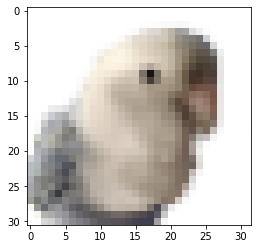

In [10]:
decoded = decode(bytez)
plt.imshow(decoded)

In [11]:
def enlarge_image(image):
    FACTOR = 4
    FACTOR_SQUARED = FACTOR * FACTOR
    height = image.shape[0] * FACTOR
    width = image.shape[1] * FACTOR
    channels = image.shape[2]
    large_image = np.zeros((height, width, channels), dtype=int)
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            for k in range(FACTOR_SQUARED):
                large_image[i * FACTOR + k % 4][j * FACTOR + k // 4] = pixel
    
    return large_image

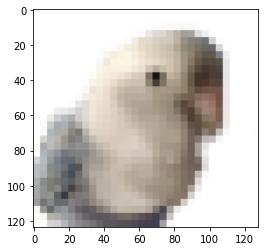

In [12]:
plt.imshow(enlarge_image(image))

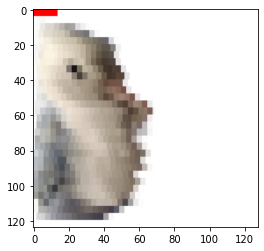

In [13]:
def visualize_compressed(bytez):
    FACTOR = 4

    p = 0

    header = bytez[p:p+4]
    p += 4
    width = int_from_bytes(bytez[p:p+4])
    p += 4
    height = int_from_bytes(bytez[p:p+4])
    p += 4
    px_len = width * height

    channels = bytez[p]
    p += 1
    colorspace = bytez[p]
    p += 1

    compressed_image = np.zeros((height  * FACTOR, width * FACTOR , channels), dtype=int)
    compressed_image[:,:,0] = 255
    compressed_image[:,:,1] = 255
    compressed_image[:,:,2] = 255
    compressed_image[:,:,3] = 255

    index = [[0, 0, 0, 0]] * 64
    run = 0
    pixel = [0, 0, 0, 255]
    chunks_len = len(bytez) - QOI_PADDING
    cur_col = 0
    
    for g in range(14):
        for k in range(FACTOR):
            compressed_image[k % 4][cur_col] = [255,0,0,255]
        cur_col += 1
            
    cur_row = -1
    for px_pos in range(0, px_len):
        if px_pos % width == 0:
            if cur_col != 0:
                cur_row += 1
            if cur_row != 0:
                cur_col = 0

        if run > 0:
            run -= 1
            continue
        elif p < chunks_len:
            b1 = bytez[p]
            p += 1

            chunk_size = 0
            if b1 & QOI_MASK_2 == QOI_INDEX:
                pixel = index[b1 ^ QOI_INDEX]
                chunk_size = 1
            elif (b1 & QOI_MASK_3) == QOI_RUN_8:
                run = (b1 & 0x1f)
                chunk_size = 1
            elif (b1 & QOI_MASK_3) == QOI_RUN_16:
                b2 = bytez[p]
                p += 1
                run = (((b1 & 0x1f) << 8) | (b2)) + 32
                chunk_size = 2
            elif (b1 & QOI_MASK_2) == QOI_DIFF_8:
                pixel[0] += (((b1 >> 4) & 0x03) - 2)
                pixel[1] += (((b1 >> 2) & 0x03) - 2)
                pixel[2] += (( b1       & 0x03) - 2)
                pixel[0] = pixel[0] % 256
                pixel[1] = pixel[1] % 256
                pixel[2] = pixel[2] % 256
                chunk_size = 1
            elif (b1 & QOI_MASK_3) == QOI_DIFF_16:
                b2 = bytez[p]
                p += 1
                pixel[0] += (b1 & 0x1f) - 16
                pixel[1] += (b2 >> 4)   -  8
                pixel[2] += (b2 & 0x0f) -  8
                chunk_size = 2
            elif (b1 & QOI_MASK_4) == QOI_DIFF_24:
                b2 = bytez[p]
                p += 1
                b3 = bytez[p]
                p += 1
                pixel[0] += (((b1 & 0x0f) << 1) | (b2 >> 7)) - 16
                pixel[1] +=  ((b2 & 0x7c) >> 2) - 16
                pixel[2] += (((b2 & 0x03) << 3) | ((b3 & 0xe0) >> 5)) - 16
                pixel[3] +=   (b3 & 0x1f) - 16
                chunk_size = 3
            elif (b1 & QOI_MASK_4) == QOI_COLOR:
                if b1 & 8:
                    pixel[0] = bytez[p]
                    p += 1
                    chunk_size += 1
                if b1 & 4:
                    pixel[1] = bytez[p]
                    p += 1
                    chunk_size += 1
                if b1 & 2:
                    pixel[2] = bytez[p]
                    p += 1
                    chunk_size += 1
                if b1 & 1:
                    pixel[3] = bytez[p]
                    p += 1
                    chunk_size += 1

            pixel[0] = pixel[0] % 256
            pixel[1] = pixel[1] % 256
            pixel[2] = pixel[2] % 256

            index_pos = QOI_COLOR_HASH(pixel) % 64
            index[index_pos] = pixel.copy()

        for g in range(chunk_size):
            for k in range(FACTOR):
                compressed_image[cur_row * 4 + k % 4][cur_col] = pixel
            cur_col += 1
        
    return compressed_image

plt.imshow(visualize_compressed(bytez))

In [14]:
def pad(image):
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]
    padded = np.zeros((height + 8, width + 8, channels), dtype=int)
    padded[:,:,0] = 0
    padded[:,:,1] = 0
    padded[:,:,2] = 0
    padded[:,:,3] = 255
    
    padded[4:-4, 4:-4] = image
    
    return padded



True

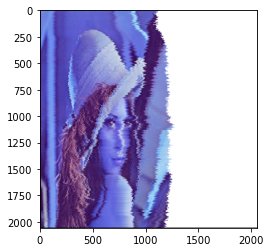

In [15]:
name = "Lenna"
image = cv2.imread(name + '.png', cv2.IMREAD_UNCHANGED)
image= cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

bytez = encode(image)
decoded = decode(bytez)
visualized = pad(visualize_compressed(bytez))
plt.imshow(visualized)


cv2.imwrite(name + '_compressed.png', visualized)

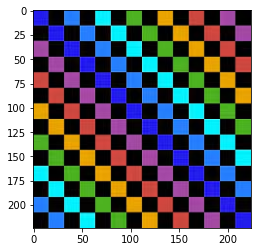

True

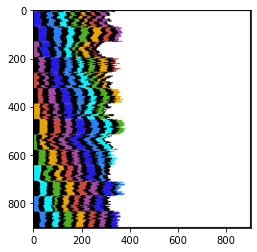

In [16]:
name = "asd"
image = cv2.imread(name + '.png', cv2.IMREAD_UNCHANGED)
image= cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

bytez = encode(image)
decoded = decode(bytez)
plt.imshow(decoded)
plt.show()
visualized = pad(visualize_compressed(bytez))
plt.imshow(visualized)


cv2.imwrite(name + '_compressed.png', visualized)
cv2.imwrite(name + '_large.png', pad(enlarge_image(decoded)))